### Kaggle房價預測

 https://www.kaggle.com/c/house-prices-advanced-regression-techniques/kernels 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')

In [2]:
# # read data
# train = pd.read_csv('E:/machineLearning/houseprice/train.csv')
# test = pd.read_csv('E:/machineLearning/houseprice/test.csv')
# sample = pd.read_csv('E:/machineLearning/houseprice/sample_submission.csv')
# # train = pd.DataFrame(train)

In [3]:
# read data
train = pd.read_csv('C:/Users/Student/Downloads/Kaggle/train.csv')
test = pd.read_csv('C:/Users/Student/Downloads/Kaggle/test.csv')
sample = pd.read_csv('C:/Users/Student/Downloads/Kaggle/sample_submission.csv')
train = train.iloc[:,1:] # drop 'Id'
test = test.iloc[:,1:] # drop 'Id'
train.shape # (1460, 80)

(1460, 80)

In [4]:
train.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

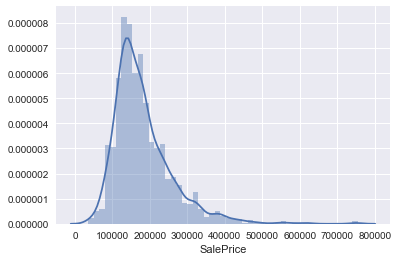

In [5]:
sns.distplot(train['SalePrice']);

In [6]:
# train['SalePrice'] summary
pd.DataFrame(train['SalePrice']).describe()

,SalePrice
count,1460.000000
mean,180921.195890
std,79442.502883
min,34900.000000
25%,129975.000000
50%,163000.000000
75%,214000.000000
max,755000.000000


<Figure size 1440x1440 with 0 Axes>

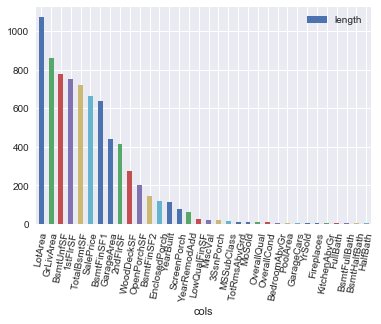

3

In [7]:
# 抓出數值型欄位
train_type = train.dtypes
float_cols = pd.Series(train_type[train_type=='float64']) # 3 float_columns: LotFrontage MasVnrArea GarageYrBlt

int_cols = pd.Series(train_type[train_type=='int64']) # 35 int_columns
int_cols_len = [len(set(train[i])) for i in int_cols.index] # 每個 int_columns 唯一值的長度
df_int_cols_len = pd.DataFrame({'cols':int_cols.index,'length':int_cols_len}) # convert DataFrame
df_int_cols_len = df_int_cols_len.sort_values('length',ascending=False) # sort by 'length'

plt.figure(1,figsize=(20,20)) # bar: int_columns 唯一值的長度 
df_int_cols_len.plot('cols','length',kind='bar',rot='80')
plt.show()

numeric_cols_int = df_int_cols_len[df_int_cols_len['length']>15] # 抓出 int_columns 的數值型欄位
numeric_cols_int = numeric_cols_int['cols'] # int_columns 的數值型欄位: 19 columns
numeric_cols = pd.Series(np.hstack((float_cols.index,numeric_cols_int))) # total: 22 numeric columns

train[numeric_cols].isnull().any().sum() # float_cols.index (LotFrontage MasVnrArea GarageYrBlt) 有空值,其他數值型欄位沒有空值

null columns total:  19


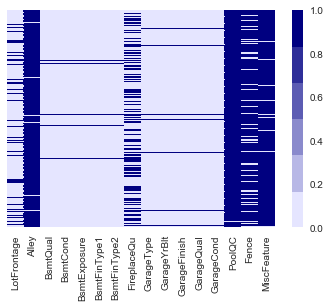

In [8]:
# check 空值
print('null columns total: ',train.isnull().any().sum()) # 空值 19 cols : drop 4 cols, continous 3 cols, category 12 cols
cmap=sns.light_palette("navy", reverse=False)
train_more_null = train[train.columns[train.isnull().sum() > 10]]
sns.heatmap(train_more_null.isnull().astype(np.int8),yticklabels=False,cmap=cmap) # null by heatmap 

In [9]:
# drop columns
drop_cols_list_mask = train.isnull().sum() > len(train['SalePrice']) * 0.4 # 篩選空值超過40%的欄位
drop_cols_list = train.columns[drop_cols_list_mask]# list of drop
train = train.drop(drop_cols_list,axis=1) # drop 
test = test.drop(drop_cols_list,axis=1) # drop 

In [10]:
# train test空值填補: numeric col: mean()
from sklearn.preprocessing import Imputer

null_cols_list = train.columns[train.isnull().any().values]
null_cols_list_test = test.columns[test.isnull().any().values]
print('null columns: \n',null_cols_list)

imp_numeric = Imputer(strategy='mean') # 數值型欄位填補均值
train[numeric_cols] = imp_numeric.fit_transform(train[numeric_cols])
numeric_cols_test = np.hstack((numeric_cols[0:8], numeric_cols[9:]))
test[numeric_cols_test] = imp_numeric.fit_transform(test[numeric_cols_test])

null columns: 
 Index(['LotFrontage', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical',
       'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual',
       'GarageCond'],
      dtype='object')


In [11]:
# train 空值填補: category: most_frequent
for i in range(len(null_cols_list)): # 類別型欄位填補眾數
    col = train[null_cols_list].columns[i] # 提取空值欄位
    train[col] = train[col].replace(['None'],np.nan) # None 取代為 nan
    unique1 =  train[col].unique()[0] # 提取唯一值準備填補
    train[col] = train[col].fillna(unique1) # 隨機填充第一個唯一值， nan一般在最後位置
    train[col] = train[col].fillna(train[col].mode()) # 重新填充眾數

In [12]:
# test 空值填補: category: most_frequent   
for i in range(len(null_cols_list_test)): # 類別型欄位填補眾數
    col = test[null_cols_list_test].columns[i] # 提取空值欄位
    test[col] = test[col].replace(['None'],np.nan) # None 取代為 nan
    unique1 =  test[col].unique()[0] # 提取唯一值準備填補
    test[col] = test[col].fillna(unique1) # 隨機填充第一個唯一值， nan一般在最後位置
    test[col] = test[col].fillna(test[col].mode()) # 重新填充眾數
test['MasVnrType'] = test['MasVnrType'].fillna('BrkFace')

In [13]:
assert train[null_cols_list].isnull().any().sum() == 0, 'Error 還有空值'# 檢查train是否還有空值

In [14]:
assert test[null_cols_list_test].isnull().any().sum() == 0, 'Error 還有空值'# 檢查test是否還有空值

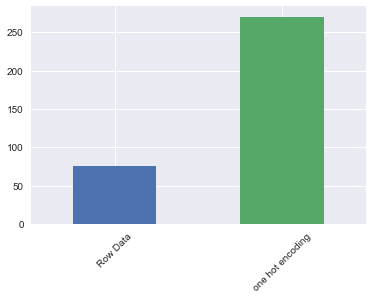

In [15]:
# one hot encoding
train_dums = pd.get_dummies(train)
test_dums = pd.get_dummies(test)

# 對比 one hot encoding 前後欄位的數量
y = train_dums.shape[1] # 270 columns
x = train.shape[1] # 75 columns
pd.Series([x,y],index=['Row Data','one hot encoding'])\
    .plot(kind='bar',rot=45)

In [16]:
# 數值標準化 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
temp = train_dums.drop('SalePrice',axis=1)
for i in range(len(temp.columns)):
    temp.iloc[:,i] = scaler.fit_transform(temp.iloc[:,i].values.reshape(-1,1))
train_dums = pd.concat([temp,train_dums['SalePrice']],axis=1)
train_dums.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SalePrice
0,0.073375,-0.229372,-0.207142,0.651479,-0.517200,1.050994,0.878668,0.511418,0.575425,-0.288653,...,-0.301962,-0.045376,0.390293,-0.272616,-0.052414,-0.091035,-0.117851,0.467651,-0.305995,208500.0
1,-0.872563,0.451936,-0.091886,-0.071836,2.179628,0.156734,-0.429577,-0.574410,1.171992,-0.288653,...,-0.301962,-0.045376,0.390293,-0.272616,-0.052414,-0.091035,-0.117851,0.467651,-0.305995,181500.0
2,0.073375,-0.093110,0.073480,0.651479,-0.517200,0.984752,0.830215,0.323060,0.092907,-0.288653,...,-0.301962,-0.045376,0.390293,-0.272616,-0.052414,-0.091035,-0.117851,0.467651,-0.305995,223500.0
3,0.309859,-0.456474,-0.096897,0.651479,-0.517200,-1.863632,-0.720298,-0.574410,-0.499274,-0.288653,...,-0.301962,-0.045376,0.390293,3.668167,-0.052414,-0.091035,-0.117851,-2.138345,-0.305995,140000.0
4,0.073375,0.633618,0.375148,1.374795,-0.517200,0.951632,0.733308,1.364570,0.463568,-0.288653,...,-0.301962,-0.045376,0.390293,-0.272616,-0.052414,-0.091035,-0.117851,0.467651,-0.305995,250000.0


In [17]:
for i in range(len(test_dums.columns)):
    test_dums.iloc[:,i] = scaler.fit_transform(test_dums.iloc[:,i].values.reshape(-1,1))   
    
# train_dums.head()

In [18]:
# 提取相關係數 >0.5 or <-0.5 的欄位
corr_train = train_dums.corr() # 所有欄位的相關係數
corr_train_cols1 = corr_train['SalePrice'][corr_train['SalePrice'].values > 0.5].index # 相關係數大於 0.5 的欄位 13 columns
corr_train_cols2 = corr_train['SalePrice'][corr_train['SalePrice'].values < -0.5].index ## 相關係數小於 -0.5 的欄位 2 columns
corr_train_cols = np.hstack((corr_train_cols1,corr_train_cols2)) # 合併所有正負相關係數較大的欄位 15 columns

<Figure size 432x288 with 0 Axes>

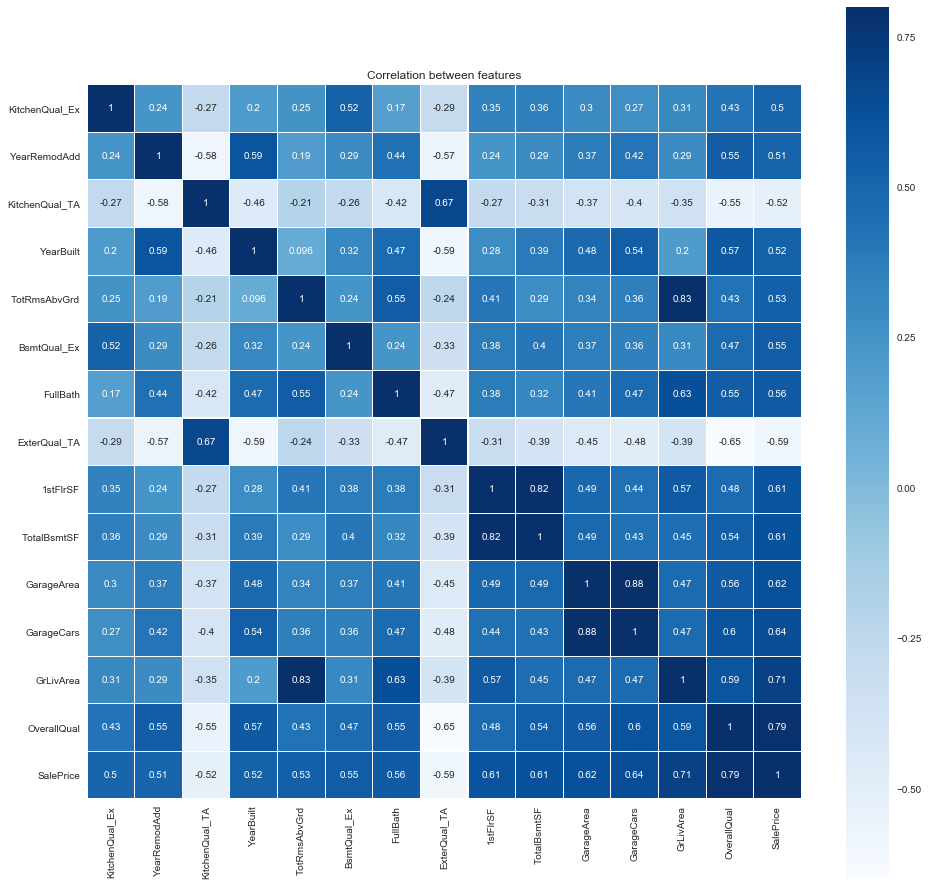

In [19]:
# correlation heatmap
train_dums_corr = train_dums[corr_train_cols] # 抓取相關係數高的 DataFrame
corr_train_cols_sorted = train_dums_corr.corr()['SalePrice'].apply(lambda x: np.abs(x)).sort_values(ascending=True) # 將 feature 排序，存成series
train_dums_corr = train_dums[corr_train_cols_sorted.index] # 抓取相關係數高且排序后的 DataFrame

corr_train_cols_sorted_test = corr_train_cols_sorted[0:-1]
test_dums_corr = test_dums[corr_train_cols_sorted_test.index] # 抓取相關係數高且排序后的 DataFrame

plt.figure(1)
plt.subplots(figsize=(16,16))
sns.heatmap(train_dums_corr.corr(),vmax=.8,linewidths=0.01, cmap='Blues',annot=True,square = True)
plt.title('Correlation between features')
plt.show()

<Figure size 432x288 with 0 Axes>

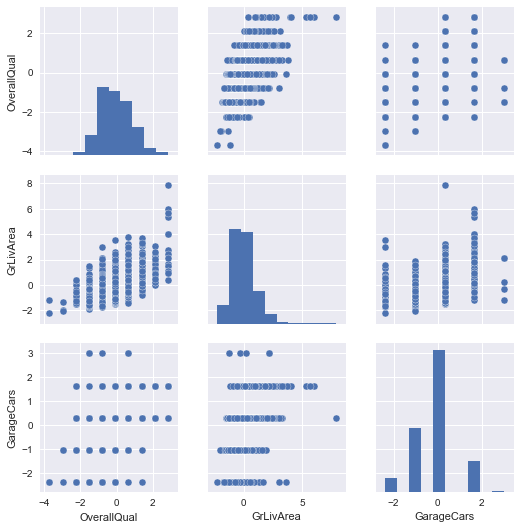

In [20]:
# 相關性前 3 features 之間的 pairplot
plt.figure(2)
sns.pairplot(data=train_dums_corr,vars=['OverallQual', 'GrLivArea', 'GarageCars'])
plt.show()

In [21]:
import xgboost as xgb
from sklearn.decomposition import PCA

trainx = train_dums_corr.iloc[:,0:-1]
trainy = train_dums_corr['SalePrice']
data_train = xgb.DMatrix(trainx,label=trainy)
data_test = xgb.DMatrix(test_dums_corr,label=trainy)

In [22]:
# model
param = {}
param['objective'] = 'reg:linear' # 做線性回歸
param['tree_method'] = 'hist'
param['silent']=1
param['max_depth']=10
num_round = 50
eval_list  = [(data_train,'train')]
eval_history = {}

# 訓練模型
model = xgb.train( param, data_train, num_round,eval_list,
                  evals_result=eval_history,verbose_eval=False)

[17:06:06] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


In [23]:
predy = model.predict(data_test)
predy

array([131864.69, 150928.98, 176011.64, ..., 154643.  , 115158.1 ,
       214016.19], dtype=float32)

In [24]:
test_summition = pd.read_csv('C:/Users/Student/Downloads/Kaggle/test.csv')
test_summition = pd.DataFrame({'Id':test_summition['Id'],'SalePrice':pd.Series(predy)})
test_summition.shape

(1459, 2)

In [25]:
test_summition.to_csv('C:/Users/Student/Downloads/Kaggle/test_summition.csv')

In [ ]:
# split
from sklearn.model_selection import train_test_split
x = train_dums_corr.iloc[:,:-1].values
y = train_dums_corr['SalePrice'].values
train_x,test_x,train_y,test_y = train_test_split(x,y,test_size = 0.3)

## LinearRegression

In [ ]:
# standrize
scaler_linearReg = scaler.fit(train_x)
train_x = scaler_linearReg.transform(train_x)
test_x = scaler_linearReg.transform(test_x)

from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
model = regressor.fit(train_x,train_y)

In [ ]:
from sklearn.metrics import r2_score
pred_y = model.predict(test_x)
r2_score(test_y,pred_y)

## 多項式迴歸

In [ ]:
train_square = np.hstack([train_x,train_x**2])
test_square = np.hstack([test_x,test_x**2])

regressor = LinearRegression()
model = regressor.fit(train_square,train_y)

pred_y = model.predict(test_square)
r2_score(test_y,pred_y)

## Lasso Regression

In [ ]:
from sklearn.linear_model import Lasso
regressor = Lasso(max_iter = 10000000)
model = regressor.fit(train_square,train_y)

pred_y = model.predict(test_square)
r2_score(test_y,pred_y)

In [ ]:
model.coef_
model.intercept_

## Ridge Regression

In [ ]:
from sklearn.linear_model import Ridge
regressor = Ridge()
model = regressor.fit(train_square,train_y)

pred_y = model.predict(test_square)
r2_score(test_y,pred_y)

## Elastic Net Regression

In [ ]:
from sklearn.linear_model import ElasticNet
regressor = ElasticNet()
model = regressor.fit(train_square,train_y)

pred_y = model.predict(test_square)
r2_score(test_y,pred_y)

## Decision Tree

In [ ]:
from sklearn import tree
from sklearn.metrics import classification_report
classifier = tree.DecisionTreeClassifier()
model = classifier.fit(train_x,train_y.astype('int'))

pred_y = model.predict(test_x)
print(classification_report(test_y.astype('int'),pred_y))

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier()
model = classifier.fit(train_x,train_y.astype('int'))

pred_y = model.predict(test_x)
print(classification_report(test_y.astype('int'),pred_y))

### XGBoost

In [ ]:
import xgboost as xgb
from sklearn.decomposition import PCA
data_train = xgb.DMatrix(train_x,label=train_y)
data_test = xgb.DMatrix(test_x,label=test_y)

pca = PCA(n_components=1) # PCA 降維
pca = pca.fit(train_x)
print(pca.n_components_)

reduce_train_x = np.dot(train_x,pca.n_components_)
reduce_test_x = np.dot(test_x,pca.n_components_)

reduce_train_x = xgb.DMatrix(reduce_train_x,label=train_y)
reduce_test_x = xgb.DMatrix(reduce_test_x,label=test_y)

In [ ]:
# PCA ,訓練模型和 r2 檢測
param = {}
param['objective'] = 'reg:linear' # 做線性回歸
param['tree_method'] = 'hist'
param['silent']=1
param['max_depth']=10
eval_list  = [(data_train,'train'),(data_test,'test')]
num_round = 50
eval_history={}

model = xgb.train( param, reduce_train_x, num_round,eval_list,
                  evals_result=eval_history,verbose_eval=False)

print('rms error: ',model.eval(reduce_test_x))

pred_y = model.predict(reduce_test_x)
r2_score(test_y,pred_y)

In [ ]:
# 訓練模型和 r2 檢測
param = {}
param['objective'] = 'reg:linear' # 做線性回歸
param['tree_method'] = 'hist'
param['silent']=1
param['max_depth']=10
eval_list  = [(data_train,'train'),(data_test,'test')]
num_round = 50
eval_history={}

model = xgb.train( param, data_train, num_round,eval_list,
                  evals_result=eval_history,verbose_eval=False)

print('rms error: ',model.eval(data_test))

pred_y = model.predict(data_test)
r2_score(test_y,pred_y)

In [ ]:
rmse_train = eval_history['train']['rmse']
rmse_test = eval_history['test']['rmse']

plt.plot(rmse_train,ms=10,marker='v',label='train_eval')
plt.plot(rmse_test,ms=10,marker='v',label='test_eval')
plt.legend()
plt.show()

In [ ]:
from xgboost import plot_importance
plot_importance(model)
plt.show()